# 전이 학습 

In [63]:
import numpy as np
import pandas as pd
import tensorflow as tf
from warnings import filterwarnings
filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 7)
import seaborn as sns
sns.set()

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications import VGG16

### 전이 학습(transfer learning)
- 수만장에 달하는 기존의 이미지에서 학습한 정보를 가져와 내 프로젝트에 활용하는 것
- 방대한 자료를 통해 미리 학습한 가중치 값을 가져와 내 프로젝트에 사용하는 방법
- 예측률을 높일 수 있다

### MRI 뇌 사진 보고 치매 환자의 뇌인지, 일반인의 뇌인지 예측
데이터 폴더 구성
- MRI
    - train
        - ad: 치매 환자 뇌 사진
        - normal: 일반인 뇌 사진
    - test
        - ad: 치매 환자 뇌 사진
        - normal: 일반인 뇌 사진

In [2]:
# seed 설정
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# 이미지 생성 옵션 설정 - 이미지 데이터 수 확장

# rescale: 주어진 이미지의 크기를 바꾸어 준다 RGB값이 0~255이므로 255로 나누면 0~1의 값으로 변환되어 학습이 좀 더 빠르고 쉬워진다
# horizontal_flip, vertical_flip: 주어진 이미지를 수평 또는 수직으로 뒤집는다
# zoom_range: 정해진 범위 안에서 축소 또는 확대한다
# width_shift, height_shift: 정해진 범위 안에서 그림을 수평 또는 수직으로 랜덤하게 평행 이동시킨다
# rotation_range: 정해진 각도만큼 이미지를 회전시킨다
# shear_range: 좌표 하나를 고정시키고 다른 몇 개의 좌표를 이동시키는 변환
# fill_mode: 이미지를 축소 또는 회전하거나 이동할 때 생기는 빈 공간을 어떻게 채울지 결정한다. nearest 옵션을 선택하면 가장 비슷한 색으로 채워진다
train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  fill_mode='nearest')

In [4]:
# 테스트셋은 실제 정보를 그대로 유지하게 하는 편이 과적합의 위험을 줄일 수 있다
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# 이미지 불러오기

# target_size: 이미지 크기
# class_mode: 치매/정상 2진 분류이므로 바이너리 모드로 실행
train_generator = train_datagen.flow_from_directory('./data/MRI/train',
                                 target_size=(150, 150),
                                 batch_size=10,
                                 class_mode='binary')

test_generator = test_datagen.flow_from_directory('./data/MRI/test',
                                                 target_size=(150, 150),
                                                 batch_size=10,
                                                 class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


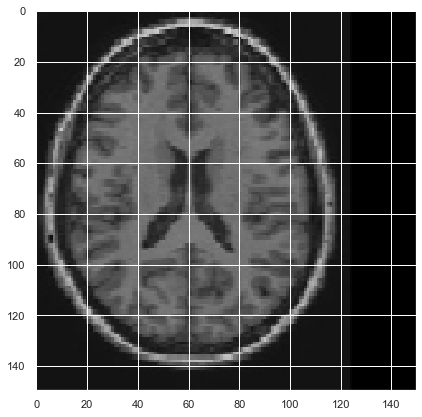

In [6]:
# 이미지 확인
x_train, y_train = train_generator.next()

plt.imshow(x_train[0])
plt.show()

#### CNN 모델

In [7]:
# 모델 설정
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [9]:
# 모델 컴파일
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
len(train_generator), len(test_generator)

(16, 12)

In [11]:
# 모델 실행
history = model.fit_generator(train_generator,
                             steps_per_epoch=len(train_generator),
                             epochs=20,
                             validation_data=test_generator,
                             validation_steps=len(test_generator))

Epoch 1/20
16/16 [==============================] - 6s 328ms/step - loss: 0.6943 - accuracy: 0.5315 - val_loss: 0.6860 - val_accuracy: 0.6000
Epoch 2/20
16/16 [==============================] - 5s 277ms/step - loss: 0.7104 - accuracy: 0.4167 - val_loss: 0.6803 - val_accuracy: 0.5500
Epoch 3/20
16/16 [==============================] - 4s 271ms/step - loss: 0.6926 - accuracy: 0.5224 - val_loss: 0.6778 - val_accuracy: 0.5667
Epoch 4/20
16/16 [==============================] - 5s 278ms/step - loss: 0.6764 - accuracy: 0.5515 - val_loss: 0.6420 - val_accuracy: 0.5750
Epoch 5/20
16/16 [==============================] - 4s 270ms/step - loss: 0.6404 - accuracy: 0.6554 - val_loss: 0.6408 - val_accuracy: 0.5500
Epoch 6/20
16/16 [==============================] - 4s 277ms/step - loss: 0.5886 - accuracy: 0.6911 - val_loss: 0.6678 - val_accuracy: 0.5500
Epoch 7/20
16/16 [==============================] - 4s 267ms/step - loss: 0.5757 - accuracy: 0.6741 - val_loss: 0.3623 - val_accuracy: 0.9083
Epoch 

In [12]:
# 정확도
model.evaluate_generator(test_generator)[1]

0.9166666865348816

In [14]:
# 정확도, 오차 변수 저장
acc = history.history['accuracy']
loss = history.history['loss']
v_acc = history.history['val_accuracy']
v_loss = history.history['val_loss']

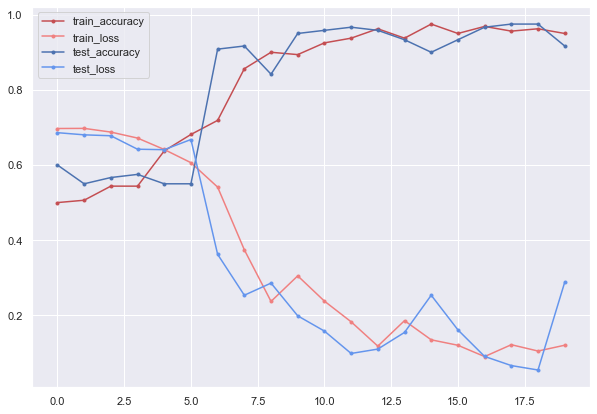

In [15]:
# 정확도, 오차 시각화
plt.plot(acc, marker='.', c='r', label='train_accuracy')
plt.plot(loss, marker='.', c='lightcoral', label='train_loss')
plt.plot(v_acc, marker='.', c='b', label='test_accuracy')
plt.plot(v_loss, marker='.', c='cornflowerblue', label='test_loss')
plt.legend()
plt.show()

epoch가 18쯤에 가장 성능이 좋고 그 이후로 과적합 됨을 확인할 수 있다

In [38]:
# 샘플 데이터
x, y = test_generator.next()

In [40]:
x.shape, y.shape

((10, 150, 150, 3), (10,))

In [44]:
# 예측
y_pred = (model.predict(x) > 0.5).astype(int)
y_pred = y_pred.reshape(-1)
y_pred

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 1])

In [43]:
y

array([0., 1., 1., 0., 0., 1., 0., 1., 0., 1.], dtype=float32)

In [46]:
# confusion matrix
pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0.0,5,0
1.0,1,4


10개중 1개 데이터를 틀리게 예측했다. 실제 치매 환자의 뇌를 정상인 뇌로 잘못 예측했다.

In [54]:
# 틀린 데이터 인덱스 추출
result = y_pred - y
sr = pd.Series(result != 0)
idx = sr[sr == True].index

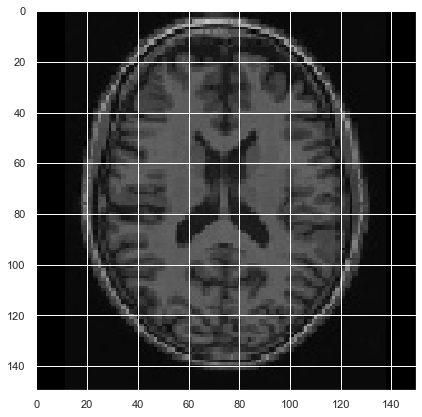

In [61]:
# 틀린 데이터 시각화
wrong = x[idx].reshape(150, 150, 3)
plt.imshow(wrong)
plt.show()

#### 전이 학습 - VGG16

In [64]:
# VGG16 모델 불러오기
# imagenet 데이터에서 미리 학습된 모델 불러온다
# VGG16의 마지막 층, 즉 분류를 담당하는 곳을 부르지 않는다(내가 만든 로컬 네트워크를 연결할 것이므로)
transfer_model = VGG16(weights='imagenet', include_top=False,
                      input_shape=(150, 150, 3))
# 불러올 부분은 새롭게 학습되는 것이 아니므로 학습이 되지 않도록 한다
transfer_model.trainable = False
transfer_model.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

학습 가능한 파라미터가 0으로 없음을 확인할 수 있다 

In [72]:
# 모델 설정
model2 = Sequential()
model2.add(transfer_model)
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(2, activation='softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [75]:
# 모델 컴파일
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [76]:
history2 = model2.fit_generator(train_generator, validation_data=test_generator, 
                     steps_per_epoch=len(train_generator),
                     epochs=20,
                     validation_steps=len(test_generator))

Epoch 1/20
16/16 [==============================] - 39s 2s/step - loss: 1.0225 - accuracy: 0.5165 - val_loss: 0.4678 - val_accuracy: 0.8833
Epoch 2/20
16/16 [==============================] - 37s 2s/step - loss: 0.4581 - accuracy: 0.8130 - val_loss: 0.3611 - val_accuracy: 0.9083
Epoch 3/20
16/16 [==============================] - 37s 2s/step - loss: 0.3322 - accuracy: 0.9260 - val_loss: 0.2856 - val_accuracy: 0.9250
Epoch 4/20
16/16 [==============================] - 38s 2s/step - loss: 0.2838 - accuracy: 0.9236 - val_loss: 0.2540 - val_accuracy: 0.9000
Epoch 5/20
16/16 [==============================] - 37s 2s/step - loss: 0.2007 - accuracy: 0.9575 - val_loss: 0.2137 - val_accuracy: 0.9333
Epoch 6/20
16/16 [==============================] - 36s 2s/step - loss: 0.2202 - accuracy: 0.9020 - val_loss: 0.1739 - val_accuracy: 0.9583
Epoch 7/20
16/16 [==============================] - 36s 2s/step - loss: 0.1579 - accuracy: 0.9658 - val_loss: 0.1602 - val_accuracy: 0.9500
Epoch 8/20
16/16 [==

In [77]:
model2.evaluate_generator(test_generator)[1]

0.949999988079071

앞서 CNN의 정확도는 92%였는데 전이 학습 결과 95%로 3%정도 정확도가 향상됐다

In [78]:
# 정확도, 오차 변수 저장
acc2 = history2.history['accuracy']
loss2 = history2.history['loss']
v_acc2 = history2.history['val_accuracy']
v_loss2 = history2.history['val_loss']

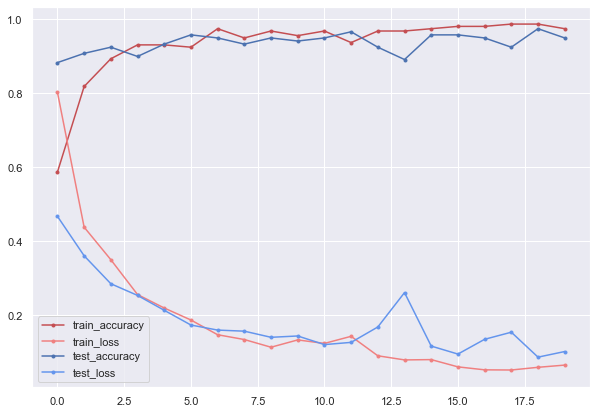

In [79]:
# 정확도, 오차 시각화
plt.plot(acc2, marker='.', c='r', label='train_accuracy')
plt.plot(loss2, marker='.', c='lightcoral', label='train_loss')
plt.plot(v_acc2, marker='.', c='b', label='test_accuracy')
plt.plot(v_loss2, marker='.', c='cornflowerblue', label='test_loss')
plt.legend()
plt.show()

In [92]:
# 예측
y_pred2 = np.argmax(model2.predict(x), axis=1)
y_pred2

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1])

In [96]:
y

array([0., 1., 1., 0., 0., 1., 0., 1., 0., 1.], dtype=float32)

In [93]:
# confusion matrix
pd.crosstab(y, y_pred2, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0.0,5,0
1.0,1,4


In [94]:
# 틀린 데이터 인덱스 추출
result = y_pred2 - y
sr = pd.Series(result != 0)
idx = sr[sr == True].index

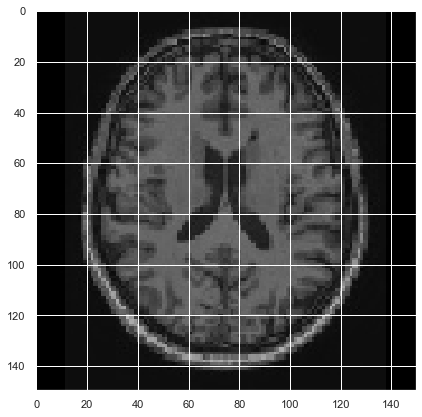

In [95]:
# 틀린 데이터 시각화
wrong = x[idx].reshape(150, 150, 3)
plt.imshow(wrong)
plt.show()